# YouTube Comments

Notebook contains initial examination of the data collected from YouTube comments on Zuckerbergs hearing with the US government. 

Data has been collected from videos posted by The Washington Post, NBC, Time, The Guardian, and Bloomberg. Each video is a full recording of the hearing each at least 4 hours long. The most popular in terms of veiws was The Washington Post. More right-leaning news sources were sought after but there didnt seem to be any full coverage from media companies such as Fox News or The Hill. Where the sources sit on the spectrum is kind of [debatable](https://www.quora.com/Which-media-outlets-in-the-USA-are-right-wing-and-which-are-left-wing) but there may be a bit of a left leaning bias in the samples collected.

First thing will be to load some needed modules and the data, starting by generally getting a feel for the sample.

In [1]:
%matplotlib inline
import collections

# --- third party modules. ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

# local functions
import plotting
from topicmodel import TopicModel

# load 100% of data and shuffle
comments = pd.read_csv('data/comments.csv').sample(frac=1)
comments.head()

,videoId,org,text,published,totalReplyCount,likeCount
670,6ValJMOpt7s,The Washington Post,"first 3 minutes and i am out , retarded",2018-04-11T05:57:16.000Z,0,0
2522,hJdxOqnCNp8,The Washington Post,3:22:35,2018-04-12T01:37:19.000Z,0,0
995,_Te_LKt5DpY,Bloomberg,We do NOT want Zuckerberg working inside of ou...,2018-04-13T00:53:14.000Z,0,1
1741,cyJosQBtzsw,Bloomberg,Stop at 1:21:14 to see Zucc giving the succ,2018-04-11T16:55:02.000Z,0,0
1955,cyJosQBtzsw,Bloomberg,"Yo guys , how do i do a mob spawner system ? D...",2018-04-10T23:39:11.000Z,2,7


### Where are comments from and in what ratio?

An inital thing can be to see where the majority of the comments have come from and how many we have got. As it turns out this loosley correlates with view counts (though their not described here). 

total comments: 2724


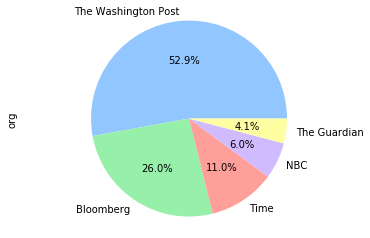

In [2]:
comments.org.value_counts().plot.pie(autopct='%1.1f%%')
plt.axis('equal')
print(f'total comments: {len(comments)}')

### Does engagement vary across different publishers?

So we know that total engagement followed as; `The Washington Post` > `Bloomberg` > `Time` > `NBC` > `The Guardian`, however is there much difference of interaction per comment. We dont have the indvidual sub-threads collected so we couldn't do a proper measure of repocicity (as in Graham, 20??). In terms of comment replies the mean counts can be ranked as `NBC` > `The Guardian` > `Bloomberg` > `Time` > `The Washington Post`. All do not show any major differences in engagement.

In [3]:
for org in set(comments.org):
    print(f'\n--- {org:20} ----------') 
    print(comments[comments.org == org].describe())


--- The Washington Post  ----------
       totalReplyCount    likeCount
count      1440.000000  1440.000000
mean          0.575694     6.045833
std           2.617596    33.977601
min           0.000000     0.000000
25%           0.000000     0.000000
50%           0.000000     0.000000
75%           0.000000     0.000000
max          32.000000   582.000000

--- The Guardian         ----------
       totalReplyCount   likeCount
count       111.000000  111.000000
mean          0.792793    5.126126
std           1.590409   13.447620
min           0.000000    0.000000
25%           0.000000    0.000000
50%           0.000000    0.000000
75%           1.000000    3.000000
max           9.000000   87.000000

--- NBC                  ----------
       totalReplyCount   likeCount
count       164.000000  164.000000
mean          0.878049    4.134146
std           2.446433   14.763379
min           0.000000    0.000000
25%           0.000000    0.000000
50%           0.000000    0.000000
75%  

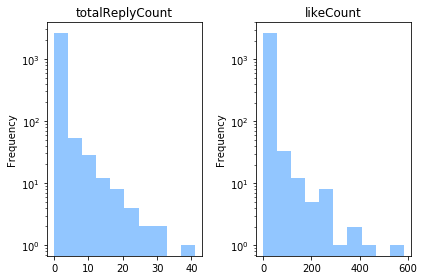

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2)
comments.totalReplyCount.plot.hist(ax=ax1, title='totalReplyCount')
comments.likeCount.plot.hist(ax=ax2, title='likeCount')
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.tight_layout()

## Generating text features

### Keyword extraction

The method of keyword extraction used here will be the RAKE algorithm, short for Rapid automatic keyword extraction. This is useful as it is simple to compute and produces chains of words as keyphrases from individual documents only requiring a list of stopwords as addtional data. It is best suited to texts the length of abstracts (100 - 250 words) and producing varible length results. Keyword candidates are located by splitting the text by stopwords and punctiation. 

In [5]:
def word_count(text):
    'estimate number of words splitting by whitespace'
    return len(text.split())

wcounts = comments.text.apply(word_count)
print(f'mean word count: {wcounts.mean():.2f}')
print(f'max word count: {wcounts.max():.2f}')
print(f'std word count: {wcounts.std():.2f}')

mean word count: 26.49
max word count: 1051.00
std word count: 47.20


blah blah blah











he

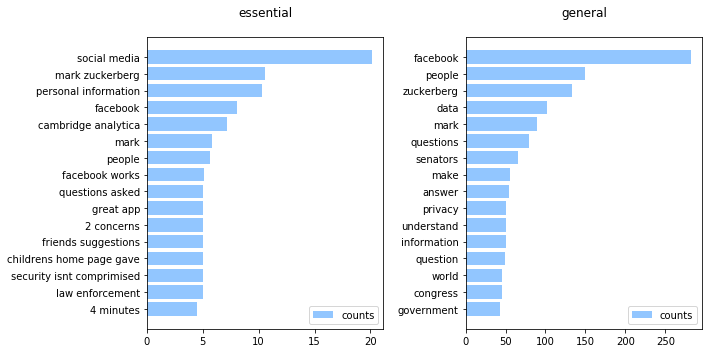

In [6]:
x = plotting.collection_keywords(comments.text)

gen = collections.Counter(x.general)
ess = collections.Counter(x.essential)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(10, 5)
plotting.plot_counter(ax1, ess, title='essential', n=16)
plotting.plot_counter(ax2, gen, title='general', n=16)
plt.tight_layout()

In [7]:
def topn(c, n):
    return set(k for k, _ in c.most_common(n))

n = len(gen) // 20 # 5%
print(n)
print(', '.join(topn(gen, n=n) & topn(ess, n=n)))

475
internet, mark, call, feel, information, explain, obama, asked, human, mark zuckerberg, social media, data, beginning, dude, face, facebook, hate speech, personal data, talk, politicians, people, delete facebook, facebook account


### Tf-idf 

Term frequency - inverse document frequencey (tf-idf) is the term frequency multiplied by the inverse document frequency $\normalsize tf \cdot idf$. Where the $tf$ is the term frequency and the inverse document frequency $idf$ is computed here as:

$\normalsize
idf = \log \frac{1 + n_d}{1 + df(d,t)} + 1
$

Where $n_d$ is the number of documents and $df(d, t)$ is the number of documents a term appears in. This is then normalised. [ref](http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting)

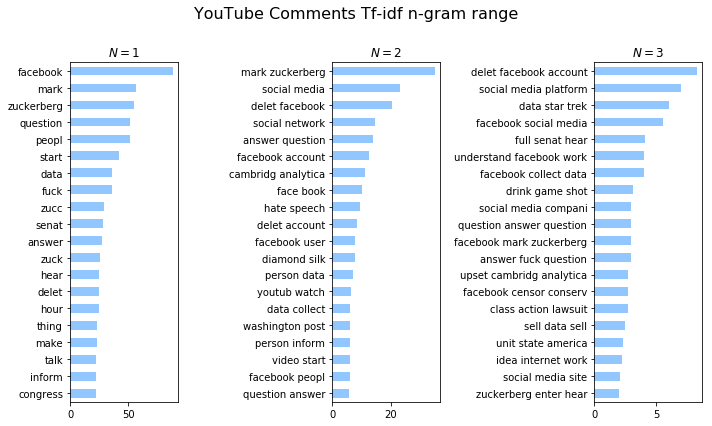

In [8]:
cleaned = comments.text.apply(plotting.clean_text)
plotting.plot_ngrams(cleaned, 1, 3, title='YouTube Comments Tf-idf n-gram range')

### Topic Modeling

...

In [14]:
t = TopicModel(n_topics=6, max_iter=500)
model = t.fit(cleaned)

Fitting LDA models with tf features, 
max_iter=500. number of topics=6. features_shape=(2724, 3922)...
Model fitted in: 158.03 secs


In [15]:
with open('data/ytTopics', 'w+') as fp:
    for top in t.topics(30):
        print(top, file=fp)

**Topic 1 - **

```
hour, lie, robot, jesus, data, open, steal, awar, holi, room, oath, quick, camera, shoe, edit, ladi, fuck, shit, evad, generat, statement, committe, christ, worst, yesterday, lock, make, holi shit, handler, late
```

**Topic 2 - **

```
facebook, obama, trump, white, campaign, america, great, hope, hous, resign, congress, member, hour, hillari, 2018, famili, friend, secur, court, video, white hous, nation, month, democrat, senior, hear, suck, presid, compani, director
```


**Topic 3 - **

```
zuckerberg, mark, start, mark zuckerberg, human, zucc, watch, cruz, lizard, hear, love, video, danger, water, speak, eye, democraci, good, conserv, testifi, liber, robot, trust, peopl, youtub, green, senat, notic, hero, girl
```

**Topic 4 - **

```
facebook, peopl, question, data, general, inform, make, user, person, answer, thing, work, senat, govern, post, mark, compani, understand, zuckerberg, privaci, talk, internet, congress, share, world, free, ask, public, control, hear
```

**Topic 5 - **

```
zuck, interview, team, shot, blink, race, myspac, imag, surpris, standard, zuckerman, everytim, lmfao, second, real, disrespect, follow, chip, intent, michael, post, communiti, zuck zuck, tattoo, potato, potato chip, grandson, absolut, team follow, chose
```

**Topic 6 - **

```
social, fuck, media, social media, shit, facebook, mark, peopl, half, network, mind, social network, creat, year, feel, question, live, hell, word, seat, stop, diamond silk, diamond, silk, protect, congress, good, simpli, money, blah
```

**Topic 7 - **

```
delet, account, facebook, face, delet facebook, facebook account, liar, book, delet account, face book, rush, shit, data, log, suit, drink, zuckerberg, facebook track, liar liar, privaci, track, nice, haha, login, hold, delet post, final, forev, power, action
```